# 08__deletions
# analyzing single-nucleotide deletions MPRA and preparing input for MIND

in this notebook, i do two things: (1) i calculate the effect size of deletions (log2 foldchange between the deletion activity and the reference activity) from the deletion MPRA and (2) i compare those effect sizes to the number of TF motifs that are computationally predicted by FIMO to be gained or lost by the deletion. note that these FIMO predictions are done separately. 

------

figures in this notebook:
- **Fig 3B, S9A**: scatter plots showing the comparison between deletion effect sizes and motif disruptions
- **Fig 3C, S9B**: specific examples of deletion profiles across a sequence (HOTAIR and DLEU1) and how they compare to motif disruption profiles

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time

from itertools import chain
from decimal import Decimal
from matplotlib import gridspec
from random import shuffle
from scipy import stats
from scipy import signal
from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *
from del_utils import *

%matplotlib inline

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
activ_dir = "../../data/02__activs"
pval_dir = "../../data/03__pvals"
index_dir = "../../data/00__index"

In [4]:
pool2_hepg2_barc_activ_f = "%s/POOL2__pMPRA1__HepG2__activities_per_barcode.txt" % (activ_dir)
pool2_k562_barc_activ_f = "%s/POOL2__pMPRA1__K562__activities_per_barcode.txt" % (activ_dir)

pool2_hepg2_elem_activ_f = "%s/POOL2__pMPRA1__HepG2__activities_per_element.txt" % (activ_dir)
pool2_k562_elem_activ_f = "%s/POOL2__pMPRA1__K562__activities_per_element.txt" % (activ_dir)

pool2_hepg2_pvals_f = "%s/POOL2__pMPRA1__HepG2__pvals.txt" % (pval_dir)
pool2_k562_pvals_f = "%s/POOL2__pMPRA1__K562__pvals.txt" % (pval_dir)

In [5]:
pool2_index_f = "%s/dels_oligo_pool.index.txt" % (index_dir)
pool2_index_del_f = "%s/dels_oligo_pool.index.with_deletion_info.txt" % (index_dir)

In [6]:
annot_f = "%s/tssid_all_biotypes.txt" % (index_dir)
tfbs_f = "../../misc/03__fimo/pool2_n_motifs_map.txt"

## 1. import data

In [7]:
hepg2_elem_res = pd.read_table(pool2_hepg2_elem_activ_f, sep="\t")
k562_elem_res = pd.read_table(pool2_k562_elem_activ_f, sep="\t")
hepg2_elem_res.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10
0,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,-1.790824,-1.506121,-1.253360,-1.425010,-1.616346,-1.290745,-1.357850,-1.364172
1,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.654425,-0.593675,-0.604614,-0.724685,-0.759409,-0.652865,-0.591606,-0.501004
2,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,ACGGGTGCCCACCTGGGAACAGGAGGCTTGGTTCCACGGCTGGGCT...,-1.210300,-1.264010,-1.127320,-1.101221,-1.304477,-1.178312,-1.065390,-1.429695
3,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.469084,0.792547,0.496125,0.538051,0.669531,0.552507,0.692894,0.565142
4,CONTROL_SNP_INDIV__control.noflip.NA__p1@HBB__...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,-1.703193,-1.657239,-1.342610,-1.407414,-1.560008,-1.441266,-1.275676,-1.331183


In [8]:
hepg2_barc_res = pd.read_table(pool2_hepg2_barc_activ_f, sep="\t")
k562_barc_res = pd.read_table(pool2_k562_barc_activ_f, sep="\t")
hepg2_barc_res.head()

,barcode,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10
0,AAAACAAAGTC,NaN,NaN,0.559995,NaN,NaN,NaN,NaN,NaN
1,AAAACAACGTG,-1.780485,-0.598085,-1.170739,-0.878212,-1.162959,-1.45008,-0.133118,-1.089508
2,AAAACAACTGG,NaN,NaN,-2.425661,NaN,NaN,NaN,NaN,NaN
3,AAAACAAGATG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAAACAAGATT,-1.028853,-1.208253,-3.278023,NaN,-2.543835,-4.28303,-1.792000,-0.798199


In [9]:
hepg2_wt_pvals = pd.read_table(pool2_hepg2_pvals_f, sep="\t")
k562_wt_pvals = pd.read_table(pool2_k562_pvals_f, sep="\t")
hepg2_wt_pvals.head()

,unique_id,element,oligo_type,rna_3_log2fc,rna_4_log2fc,rna_5_log2fc,rna_6_log2fc,rna_7_log2fc,rna_8_log2fc,rna_9_log2fc,...,rna_6_padj,rna_7_padj,rna_8_padj,rna_9_padj,rna_10_padj,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class
0,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,CONTROL_BUT_HAS_SNP,-0.740530,-0.483852,-0.266400,-0.420682,-0.565798,-0.276644,-0.338944,...,5.301211e-02,9.182491e-06,9.165985e-01,2.859277e-01,1.000000e+00,1.653376e-23,sig,not sig,sig,sig repressive
1,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,CONTROL_BUT_HAS_SNP,0.395869,0.428595,0.382347,0.279643,0.291139,0.361236,0.427300,...,1.000000e+00,1.000000e+00,1.552552e-01,2.618122e-02,1.545699e-03,2.506378e-15,sig,not sig,sig,sig active
2,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,ACGGGTGCCCACCTGGGAACAGGAGGCTTGGTTCCACGGCTGGGCT...,CONTROL_BUT_HAS_SNP,-0.160006,-0.241741,-0.140360,-0.096893,-0.253929,-0.164211,-0.046484,...,1.000000e+00,5.887921e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,not sig,not sig,not sig,not sig
3,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,CONTROL_BUT_HAS_SNP,1.519378,1.814816,1.483085,1.542379,1.720079,1.566608,1.711800,...,9.008623e-25,3.404805e-34,3.490157e-28,2.103572e-30,2.605472e-31,2.232976e-230,sig,sig active,sig,sig active
4,CONTROL_SNP_INDIV__control.noflip.NA__p1@HBB__...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,CONTROL_SNP_INDIV,-0.652900,-0.634970,-0.355650,-0.403086,-0.509460,-0.427165,-0.256770,...,1.095963e-01,8.470045e-04,3.288456e-01,5.823235e-01,1.000000e+00,7.097918e-23,sig,not sig,sig,sig repressive


In [10]:
index = pd.read_table(pool2_index_f, sep="\t")
index.head()

,full_oligo,oligo_type,oligo_id,dupe_info,seq_name,tile_name,chr,locus_start,locus_end,strand,...,tile_number,local_start,local_end,RE_count_1,RE_count_2,RE_count_3,SNP,barcode,element,unique_id
0,ACTGGCCGCTTCACTGTGTTCCAGAAAACAGCAGCAAACAGAGGCC...,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.1,none,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,...,2.0,94.0,208.0,1,1,0,none,GATTCGTCGTG,TGTTCCAGAAAACAGCAGCAAACAGAGGCCCTTGGATTCCGGGGTG...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...
1,ACTGGCCGCTTCACTGTGTTCCAGAAAACAGCAGCAAACAGAGGCC...,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.2,none,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,...,2.0,94.0,208.0,1,1,0,none,CGAGATAAGTT,TGTTCCAGAAAACAGCAGCAAACAGAGGCCCTTGGATTCCGGGGTG...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...
2,ACTGGCCGCTTCACTGTGTTCCAGAAAACAGCAGCAAACAGAGGCC...,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.3,none,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,...,2.0,94.0,208.0,1,1,0,none,CTCGATTAAGG,TGTTCCAGAAAACAGCAGCAAACAGAGGCCCTTGGATTCCGGGGTG...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...
3,ACTGGCCGCTTCACTGTGTTCCAGAAAACAGCAGCAAACAGAGGCC...,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.4,none,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,...,2.0,94.0,208.0,1,1,0,none,TGAATAAGTCA,TGTTCCAGAAAACAGCAGCAAACAGAGGCCCTTGGATTCCGGGGTG...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...
4,ACTGGCCGCTTCACTGTGTTCCAGAAAACAGCAGCAAACAGAGGCC...,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.5,none,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,...,2.0,94.0,208.0,1,1,0,none,CCTAATCGACA,TGTTCCAGAAAACAGCAGCAAACAGAGGCCCTTGGATTCCGGGGTG...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...


In [11]:
tfbs = pd.read_table(tfbs_f, sep="\t", header=None)
tfbs.columns = ["unique_id", "n_tfs"]
tfbs.head()

,unique_id,n_tfs
0,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,16
1,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,10
2,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,14
3,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,16
4,CONTROL_SNP_INDIV__control.noflip.NA__p1@HBB__...,16


## 2. add required deletion information to index

In [12]:
# first create a dict of del seq : wt seq map
index_dels = index[index["oligo_type"].str.contains("DELETION")][["oligo_type", "tile_name", "element"]].drop_duplicates()
print("mapping %s unique deletion sequences" % (len(index_dels)))
index_wt = index[index["oligo_type"] == "WILDTYPE"][["oligo_type", "tile_name", "element"]].drop_duplicates()
index_wt_w_snp = index[index["oligo_type"] == "WILDTYPE_BUT_HAS_SNP"][["oligo_type", "tile_name", "element"]].drop_duplicates()
index_fl = index[index["oligo_type"] == "FLIPPED"][["oligo_type", "tile_name", "element"]].drop_duplicates()
dels_dict = {}
for i, row in index_dels.iterrows():
    if "WILDTYPE_BUT_HAS_SNP" in row.oligo_type:
        seq = index_wt_w_snp[index_wt_w_snp["tile_name"] == row.tile_name]["element"].iloc[0]
    elif "WILDTYPE" in row.oligo_type:
        seq = index_wt[index_wt["tile_name"] == row.tile_name]["element"].iloc[0]
    elif "FLIPPED" in row.oligo_type:
        seq = index_fl[index_fl["tile_name"] == row.tile_name]["element"].iloc[0]
    dels_dict[row.element] = seq

mapping 3964 unique deletion sequences


In [13]:
# add deletion number to index
print("finding deletion numbers...")
index["del_num"] = index.apply(get_del_num, axis=1)

finding deletion numbers...


In [14]:
print("finding deletion bases...")
index["del_base"] = index.apply(get_del_base, seq_map=dels_dict, axis=1)

finding deletion bases...


In [15]:
index_elem = index.drop(["RE_count_1", "RE_count_2", "RE_count_3", "barcode", "full_oligo"], axis=1)
index_elem = index_elem.drop_duplicates(subset=["oligo_type", "seq_name", "dupe_info", "element"])
index_elem["dupe_info"] = index_elem.apply(fix_dupe_info, axis=1)
index_elem.head()

,oligo_type,oligo_id,dupe_info,seq_name,tile_name,chr,locus_start,locus_end,strand,tile_start,tile_end,tile_number,local_start,local_end,SNP,element,unique_id,del_num,del_base
0,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.1,1.2.0.0.0.0,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,65187624.0,2.0,94.0,208.0,none,TGTTCCAGAAAACAGCAGCAAACAGAGGCCCTTGGATTCCGGGGTG...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,0,X
80,WILDTYPE_BUT_HAS_SNP_DELETION,1.2.0.0.11.1.1,"1.2.0.0.11.1,1.2.0.0.12.1",Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,65187624.0,2.0,94.0,208.0,none,TGTTCCAGAAACAGCAGCAAACAGAGGCCCTTGGATTCCGGGGTGG...,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,11,A
106,WILDTYPE_BUT_HAS_SNP_DELETION,1.2.0.0.13.1.1,1.2.0.0.13.1,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,65187624.0,2.0,94.0,208.0,none,TGTTCCAGAAAAAGCAGCAAACAGAGGCCCTTGGATTCCGGGGTGG...,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,13,C
132,WILDTYPE_BUT_HAS_SNP_DELETION,1.2.0.0.14.1.1,1.2.0.0.14.1,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,65187624.0,2.0,94.0,208.0,none,TGTTCCAGAAAACGCAGCAAACAGAGGCCCTTGGATTCCGGGGTGG...,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,14,A
158,WILDTYPE_BUT_HAS_SNP_DELETION,1.2.0.0.15.1.1,1.2.0.0.15.1,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,65187624.0,2.0,94.0,208.0,none,TGTTCCAGAAAACACAGCAAACAGAGGCCCTTGGATTCCGGGGTGG...,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,15,G


## 3. merge with index

In [16]:
hepg2_barc = index.merge(hepg2_barc_res, left_on="barcode", right_on="barcode", how="left")
k562_barc = index.merge(k562_barc_res, left_on="barcode", right_on="barcode", how="left")
hepg2_barc.head()

,full_oligo,oligo_type,oligo_id,dupe_info,seq_name,tile_name,chr,locus_start,locus_end,strand,...,del_num,del_base,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10
0,ACTGGCCGCTTCACTGTGTTCCAGAAAACAGCAGCAAACAGAGGCC...,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.1,none,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,...,0,X,-0.410643,0.272279,0.094076,0.030652,0.060766,-0.446546,0.225989,-0.505224
1,ACTGGCCGCTTCACTGTGTTCCAGAAAACAGCAGCAAACAGAGGCC...,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.2,none,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,...,0,X,-0.188333,0.517627,-0.291708,0.394602,-0.126533,-0.024516,-0.566155,-0.180420
2,ACTGGCCGCTTCACTGTGTTCCAGAAAACAGCAGCAAACAGAGGCC...,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.3,none,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,...,0,X,0.618850,0.138554,0.149168,-0.166496,0.478421,-0.172385,0.246760,0.187198
3,ACTGGCCGCTTCACTGTGTTCCAGAAAACAGCAGCAAACAGAGGCC...,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.4,none,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,...,0,X,-0.743942,-0.886037,-0.789264,-0.849808,-0.179054,-0.370554,-1.570538,0.126095
4,ACTGGCCGCTTCACTGTGTTCCAGAAAACAGCAGCAAACAGAGGCC...,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.5,none,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,...,0,X,0.330004,-0.114620,1.211775,-0.214544,0.263450,0.284756,0.356498,-0.247038


In [17]:
hepg2 = index_elem.merge(hepg2_elem_res, on=["unique_id", "element"], how="left")
k562 = index_elem.merge(k562_elem_res, on=["unique_id", "element"], how="left")
hepg2.head()

,oligo_type,oligo_id,dupe_info,seq_name,tile_name,chr,locus_start,locus_end,strand,tile_start,...,del_num,del_base,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10
0,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.1,1.2.0.0.0.0,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,...,0,X,-0.203456,0.071141,0.089584,0.075924,0.054592,-0.059412,0.098149,0.068125
1,WILDTYPE_BUT_HAS_SNP_DELETION,1.2.0.0.11.1.1,"1.2.0.0.11.1,1.2.0.0.12.1",Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,...,11,A,-0.214458,-0.023648,-0.495514,-0.228879,0.123623,-0.102686,0.028465,-0.181398
2,WILDTYPE_BUT_HAS_SNP_DELETION,1.2.0.0.13.1.1,1.2.0.0.13.1,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,...,13,C,0.048487,-0.045041,0.100893,0.000007,-0.103560,-0.040055,-0.167797,0.002691
3,WILDTYPE_BUT_HAS_SNP_DELETION,1.2.0.0.14.1.1,1.2.0.0.14.1,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,...,14,A,-0.390815,0.126024,-0.288252,-0.050163,-0.047548,-0.107317,0.277935,-0.137774
4,WILDTYPE_BUT_HAS_SNP_DELETION,1.2.0.0.15.1.1,1.2.0.0.15.1,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,...,15,G,-0.108030,0.202503,0.055752,-0.256612,0.159802,0.228066,0.140733,0.028319


In [18]:
# add overall mean column and standard dev column
hepg2_reps = [col for col in hepg2.columns if "rna" in col]
hepg2["overall_mean"] = hepg2[hepg2_reps].mean(axis=1)
hepg2["lfcSE"] = hepg2[hepg2_reps].std(axis=1)/np.sqrt(len(hepg2_reps))

hepg2_barc["overall_mean"] = hepg2_barc[hepg2_reps].mean(axis=1)
hepg2_barc["lfcSE"] = hepg2_barc[hepg2_reps].std(axis=1)/np.sqrt(len(hepg2_reps))

In [19]:
# add overall mean column and standard dev column
k562_reps = [col for col in k562.columns if "rna" in col]
k562["overall_mean"] = k562[k562_reps].mean(axis=1)
k562["lfcSE"] = k562[k562_reps].std(axis=1)/np.sqrt(len(k562_reps))

k562_barc["overall_mean"] = k562_barc[k562_reps].mean(axis=1)
k562_barc["lfcSE"] = k562_barc[k562_reps].std(axis=1)/np.sqrt(len(k562_reps))

## 4. calculate p-value for deletions

In [20]:
hepg2_barcode_value_dict = get_barcode_value_map(hepg2, hepg2_barc, hepg2_reps)

mapping barcode values to 3964 deletion sequences
..row 0..
..row 1000..
..row 2000..
..row 3000..


In [21]:
k562_barcode_value_dict = get_barcode_value_map(k562, k562_barc, k562_reps)

mapping barcode values to 3964 deletion sequences
..row 0..
..row 1000..
..row 2000..
..row 3000..


In [22]:
hepg2_pvals, hepg2_l2fcs = calculate_p_value(hepg2_barcode_value_dict)

calculating pvalues b/w deletion and wt for 3964 deletion tiles


In [23]:
k562_pvals, k562_l2fcs = calculate_p_value(k562_barcode_value_dict)

calculating pvalues b/w deletion and wt for 3964 deletion tiles


In [24]:
# combine and adjust pvals
hepg2_all_pvals = combine_and_adjust_pvals(hepg2_pvals, hepg2_l2fcs, 0.05, hepg2_reps)
hepg2_all_pvals.sample(5)

,index,rna_3_pval,rna_4_pval,rna_5_pval,rna_6_pval,rna_7_pval,rna_8_pval,rna_9_pval,rna_10_pval,combined_pval,rna_3_l2fc,rna_4_l2fc,rna_5_l2fc,rna_6_l2fc,rna_7_l2fc,rna_8_l2fc,rna_9_l2fc,rna_10_l2fc,combined_padj,combined_sig
1907,CTGCGGGGCGGAGATGGGCAGGGGGCGGTGCGTGGGTCCCAGCTGC...,0.980128,0.143914,0.691063,0.865586,0.715316,0.233226,0.798684,0.800180,0.927297,-0.114057,0.429676,-0.096946,0.198430,-0.223877,-0.721314,-0.111569,0.052765,1.0,not sig
3096,GGGGGAGCGCGCAGCCGGCCAGTGGCGGCCTCGCCGGCGGCCTCTT...,0.988952,0.649605,0.281466,0.296270,0.381369,0.644015,0.579757,0.860883,0.848407,0.369983,-0.115877,0.436220,0.908848,0.245117,-0.204639,-0.206056,0.088318,1.0,not sig
2666,GGAAGAGTCGCTTCCGCTCCCGCCCCGCTCTGTGGCGTAGCCGGAC...,0.562541,0.523172,0.629409,0.976045,0.186428,0.749551,0.910345,0.186345,0.835189,-0.131825,-0.090576,0.102857,0.063525,-0.040284,-0.164134,0.025342,-0.173763,1.0,not sig
721,CAAATGTAGTCACGTTTCCAATTATGAATATTTTAGAACTCAGTGA...,0.852759,0.893694,0.741170,0.108806,0.024015,0.716026,0.217806,0.777858,0.540570,-0.022841,-0.004598,-0.007250,-0.228111,0.417626,0.025523,-0.085570,0.164103,1.0,not sig
356,AGCTCGGCAGCCGCTGCGCCGCCCTTTGGCACCAGAGGTGAGCAGC...,0.226236,0.231349,0.710489,0.240798,0.122002,0.076788,0.378238,0.277148,0.034911,-0.264924,-0.253910,0.151317,-0.080126,-0.164514,-0.330336,-0.172636,-0.199874,1.0,not sig


In [25]:
# combine and adjust pvals
k562_all_pvals = combine_and_adjust_pvals(k562_pvals, k562_l2fcs, 0.05, k562_reps)
k562_all_pvals.sample(5)

,index,rna_1_pval,rna_2_pval,rna_3_pval,rna_4_pval,combined_pval,rna_1_l2fc,rna_2_l2fc,rna_3_l2fc,rna_4_l2fc,combined_padj,combined_sig
439,AGTCTCGGGCTGCAGGTGCGGAGGGGAGAGCGGGGGCGGGGAGGGA...,0.116032,0.040602,0.456057,0.422678,0.052390,-4.227268,-2.822631,-0.351224,-1.303676,1.0,not sig
2099,GACACAAAAACCGTGCTTGAGTCCCCGCGCCCCTCCCCTCCCCTCC...,0.283074,0.143343,NaN,1.000000,1.000000,0.192786,-1.445436,NaN,0.179466,1.0,not sig
952,CCCTTCTTTGCTGCAATCTGGGTGCGGCTAGAGCAATTTGTCATAG...,0.874367,0.905503,0.670379,0.626589,0.946554,-0.238418,-0.339655,-0.194872,0.292191,1.0,not sig
3345,TCCCTGACGCAGCCCCACCGGTTGCGCAGTCCCTCCCCGCCCCCGC...,0.707195,0.942567,0.873845,0.713056,0.972222,-0.591703,-0.405040,-0.148828,-1.140013,1.0,not sig
2732,GGAGGAATCGTCCCGTTAGCAATGACCCCGGTGACGCGGCTGAGGG...,0.307489,0.126679,0.783922,1.000000,1.000000,1.184475,-0.925996,-0.885332,-0.985483,1.0,not sig


In [26]:
# add info back to original dfs
hepg2 = hepg2.merge(hepg2_all_pvals, left_on="element", right_on="index", how="left")
hepg2.head()

,oligo_type,oligo_id,dupe_info,seq_name,tile_name,chr,locus_start,locus_end,strand,tile_start,...,rna_3_l2fc,rna_4_l2fc,rna_5_l2fc,rna_6_l2fc,rna_7_l2fc,rna_8_l2fc,rna_9_l2fc,rna_10_l2fc,combined_padj,combined_sig
0,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.1,1.2.0.0.0.0,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,WILDTYPE_BUT_HAS_SNP_DELETION,1.2.0.0.11.1.1,"1.2.0.0.11.1,1.2.0.0.12.1",Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,...,-0.011002,-0.094789,-0.585099,-0.304803,0.069031,-0.043274,-0.069684,-0.249523,1.0,not sig
2,WILDTYPE_BUT_HAS_SNP_DELETION,1.2.0.0.13.1.1,1.2.0.0.13.1,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,...,0.251943,-0.116182,0.011308,-0.075917,-0.158152,0.019357,-0.265946,-0.065434,1.0,not sig
3,WILDTYPE_BUT_HAS_SNP_DELETION,1.2.0.0.14.1.1,1.2.0.0.14.1,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,...,-0.187358,0.054883,-0.377836,-0.126087,-0.102139,-0.047905,0.179786,-0.205900,1.0,not sig
4,WILDTYPE_BUT_HAS_SNP_DELETION,1.2.0.0.15.1.1,1.2.0.0.15.1,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,...,0.095426,0.131363,-0.033832,-0.332535,0.105210,0.287478,0.042585,-0.039807,1.0,not sig


In [27]:
# add info back to original dfs
k562 = k562.merge(k562_all_pvals, left_on="element", right_on="index", how="left")
k562.head()

,oligo_type,oligo_id,dupe_info,seq_name,tile_name,chr,locus_start,locus_end,strand,tile_start,...,rna_2_pval,rna_3_pval,rna_4_pval,combined_pval,rna_1_l2fc,rna_2_l2fc,rna_3_l2fc,rna_4_l2fc,combined_padj,combined_sig
0,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.1,1.2.0.0.0.0,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,WILDTYPE_BUT_HAS_SNP_DELETION,1.2.0.0.11.1.1,"1.2.0.0.11.1,1.2.0.0.12.1",Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,...,0.556914,0.849997,0.962435,0.950389,-0.246157,0.224402,-0.511201,0.231922,1.0,not sig
2,WILDTYPE_BUT_HAS_SNP_DELETION,1.2.0.0.13.1.1,1.2.0.0.13.1,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,...,0.404710,0.200471,0.619516,0.390514,0.122225,-0.007327,0.556734,-0.352480,1.0,not sig
3,WILDTYPE_BUT_HAS_SNP_DELETION,1.2.0.0.14.1.1,1.2.0.0.14.1,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,...,0.547251,0.527546,0.648285,0.826626,0.234730,-0.311519,0.429838,-0.099402,1.0,not sig
4,WILDTYPE_BUT_HAS_SNP_DELETION,1.2.0.0.15.1.1,1.2.0.0.15.1,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,...,0.684543,0.606288,0.976772,0.961971,0.425954,-0.066967,-0.538121,-0.008081,1.0,not sig


## 5. wrangle deletion data into format we need

In [28]:
unique_names = index_elem[index_elem.oligo_type.str.contains("DELETION")]["tile_name"].unique()
[x for x in unique_names if "Enhancer" in x]

['Enhancer.noflip.NA__chr11:65187297-65188198__chr11:65187510..65187718,-,1.2',
 'Enhancer.noflip.NA__chr11:65264635-65265953__chr11:65265021..65265229,-,2.1',
 'Enhancer.noflip.NA__chr11:65264635-65265953__chr11:65265021..65265229,-,2.2',
 'Enhancer.noflip.NA__chr20:47893075-47893400__chr20:47893097..47893305,-,3.1',
 'Enhancer.noflip.NA__chr20:47893075-47893400__chr20:47893097..47893305,-,3.2',
 'Enhancer.noflip.NA__chr3:169482089-169482431__chr3:169482079..169482287,-,4.1',
 'Enhancer.noflip.NA__chr3:169482089-169482431__chr3:169482079..169482287,-,4.2',
 'Enhancer.noflip.NA__chr7:130795999-130796263__chr7:130796089..130796297,-,5.1',
 'Enhancer.noflip.NA__chr7:130795999-130796263__chr7:130796089..130796297,-,5.2']

In [29]:
# first flatten the dataframe so dupes at seq level are dealt with
hepg2 = tidy_split(hepg2, "dupe_info", sep=",", keep=False)
k562 = tidy_split(k562, "dupe_info", sep=",", keep=False)
hepg2.head()

,oligo_type,oligo_id,dupe_info,seq_name,tile_name,chr,locus_start,locus_end,strand,tile_start,...,rna_3_l2fc,rna_4_l2fc,rna_5_l2fc,rna_6_l2fc,rna_7_l2fc,rna_8_l2fc,rna_9_l2fc,rna_10_l2fc,combined_padj,combined_sig
0,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.1,1.2.0.0.0.0,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,WILDTYPE_BUT_HAS_SNP_DELETION,1.2.0.0.11.1.1,1.2.0.0.11.1,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,...,-0.011002,-0.094789,-0.585099,-0.304803,0.069031,-0.043274,-0.069684,-0.249523,1.0,not sig
1,WILDTYPE_BUT_HAS_SNP_DELETION,1.2.0.0.11.1.1,1.2.0.0.12.1,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,...,-0.011002,-0.094789,-0.585099,-0.304803,0.069031,-0.043274,-0.069684,-0.249523,1.0,not sig
2,WILDTYPE_BUT_HAS_SNP_DELETION,1.2.0.0.13.1.1,1.2.0.0.13.1,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,...,0.251943,-0.116182,0.011308,-0.075917,-0.158152,0.019357,-0.265946,-0.065434,1.0,not sig
3,WILDTYPE_BUT_HAS_SNP_DELETION,1.2.0.0.14.1.1,1.2.0.0.14.1,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,...,-0.187358,0.054883,-0.377836,-0.126087,-0.102139,-0.047905,0.179786,-0.205900,1.0,not sig


In [30]:
# then fix deletion numbers of those that have new rows due to a dupe
hepg2["del_num_fixed"] = hepg2.apply(fix_del_num, axis=1)
k562["del_num_fixed"] = k562.apply(fix_del_num, axis=1)
hepg2.head()

,oligo_type,oligo_id,dupe_info,seq_name,tile_name,chr,locus_start,locus_end,strand,tile_start,...,rna_4_l2fc,rna_5_l2fc,rna_6_l2fc,rna_7_l2fc,rna_8_l2fc,rna_9_l2fc,rna_10_l2fc,combined_padj,combined_sig,del_num_fixed
0,WILDTYPE_BUT_HAS_SNP,1.2.0.0.0.0.1,1.2.0.0.0.0,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,WILDTYPE_BUT_HAS_SNP_DELETION,1.2.0.0.11.1.1,1.2.0.0.11.1,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,...,-0.094789,-0.585099,-0.304803,0.069031,-0.043274,-0.069684,-0.249523,1.0,not sig,11
1,WILDTYPE_BUT_HAS_SNP_DELETION,1.2.0.0.11.1.1,1.2.0.0.12.1,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,...,-0.094789,-0.585099,-0.304803,0.069031,-0.043274,-0.069684,-0.249523,1.0,not sig,12
2,WILDTYPE_BUT_HAS_SNP_DELETION,1.2.0.0.13.1.1,1.2.0.0.13.1,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,...,-0.116182,0.011308,-0.075917,-0.158152,0.019357,-0.265946,-0.065434,1.0,not sig,13
3,WILDTYPE_BUT_HAS_SNP_DELETION,1.2.0.0.14.1.1,1.2.0.0.14.1,Enhancer.noflip.NA__chr11:65187297-65188198__c...,Enhancer.noflip.NA__chr11:65187297-65188198__c...,chr11,65187510.0,65187718.0,-,65187510.0,...,0.054883,-0.377836,-0.126087,-0.102139,-0.047905,0.179786,-0.205900,1.0,not sig,14


In [31]:
hepg2_dels = wrangle_deletion_data(hepg2, unique_names, hepg2_wt_pvals)
hepg2_dels["Enhancer.noflip.NA__chr11:65264635-65265953__chr11:65265021..65265229,-,2.1"].head()

Enhancer.noflip.NA__chr7:130795999-130796263__chr7:130796089..130796297,-,5.1 is missing 1 bases: [79]
mrna.noflip.NA__p1@ZBTB37__chr1:173837344..173837552,+,9.2 is missing 8 bases: [77, 78, 79, 80, 81, 82, 83, 84]
Antisense.noflip.NA__p1@MEG3__chr14:101292281..101292489,+,17.1 is missing 1 bases: [43]
Lincrna.flip.sense__p1@CRNDE__chr16:54962763..54962971,-,18.1 is missing 6 bases: [21, 22, 23, 24, 25, 26]
Lincrna.flip.sense__p1@CRNDE__chr16:54962763..54962971,-,18.2 is missing 1 bases: [56]
Antisense.noflip.NA__p1@ZNFX1-AS1__chr20:47895005..47895213,+,22.1 is missing 1 bases: [26]
Lincrna.flip.antisense__p1@CRNDE__chr16:54962763..54962971,+,31.1 is missing 1 bases: [59]
Lincrna.flip.antisense__p1@CRNDE__chr16:54962763..54962971,+,31.2 is missing 6 bases: [89, 90, 91, 92, 93, 94]


,delpos,mean.log2FC,sd,se,seq,padj,sig,wt_activ,wt_l2fc,wt_class,tile_chr,tile_start,tile_end
67,11,-0.178531,0.383383,0.135546,T,1.0,not sig,-0.116371,0.911189,sig active,chr11,65265115.0,65265229.0
68,12,-0.451884,0.330879,0.116983,G,1.0,not sig,-0.116371,0.911189,sig active,chr11,65265115.0,65265229.0
69,13,0.157971,0.294439,0.104100,C,1.0,not sig,-0.116371,0.911189,sig active,chr11,65265115.0,65265229.0
70,14,-0.480071,0.454278,0.160612,A,1.0,not sig,-0.116371,0.911189,sig active,chr11,65265115.0,65265229.0
71,15,0.272765,0.549605,0.194315,G,1.0,not sig,-0.116371,0.911189,sig active,chr11,65265115.0,65265229.0


In [32]:
k562_dels = wrangle_deletion_data(k562, unique_names, k562_wt_pvals)
k562_dels["Enhancer.noflip.NA__chr11:65264635-65265953__chr11:65265021..65265229,-,2.1"].head()

Enhancer.noflip.NA__chr7:130795999-130796263__chr7:130796089..130796297,-,5.1 is missing 1 bases: [79]
mrna.noflip.NA__p1@ZBTB37__chr1:173837344..173837552,+,9.2 is missing 8 bases: [77, 78, 79, 80, 81, 82, 83, 84]
Antisense.noflip.NA__p1@MEG3__chr14:101292281..101292489,+,17.1 is missing 1 bases: [43]
Lincrna.flip.sense__p1@CRNDE__chr16:54962763..54962971,-,18.1 is missing 6 bases: [21, 22, 23, 24, 25, 26]
Lincrna.flip.sense__p1@CRNDE__chr16:54962763..54962971,-,18.2 is missing 1 bases: [56]
Antisense.noflip.NA__p1@ZNFX1-AS1__chr20:47895005..47895213,+,22.1 is missing 1 bases: [26]
Lincrna.flip.antisense__p1@CRNDE__chr16:54962763..54962971,+,31.1 is missing 1 bases: [59]
Lincrna.flip.antisense__p1@CRNDE__chr16:54962763..54962971,+,31.2 is missing 6 bases: [89, 90, 91, 92, 93, 94]


,delpos,mean.log2FC,sd,se,seq,padj,sig,wt_activ,wt_l2fc,wt_class,tile_chr,tile_start,tile_end
67,11,0.139440,1.632326,0.816163,T,1.0,not sig,1.164245,2.322216,sig active,chr11,65265115.0,65265229.0
68,12,-1.069173,1.283795,0.641897,G,1.0,not sig,1.164245,2.322216,sig active,chr11,65265115.0,65265229.0
69,13,-1.045590,0.632650,0.316325,C,1.0,not sig,1.164245,2.322216,sig active,chr11,65265115.0,65265229.0
70,14,0.123362,0.582553,0.291277,A,1.0,not sig,1.164245,2.322216,sig active,chr11,65265115.0,65265229.0
71,15,-0.486999,0.700334,0.350167,G,1.0,not sig,1.164245,2.322216,sig active,chr11,65265115.0,65265229.0


In [33]:
k562_dels["Antisense.noflip.NA__p1@MEG3__chr14:101292281..101292489,+,17.1"].head()

,delpos,mean.log2FC,sd,se,seq,padj,sig,wt_activ,wt_l2fc,wt_class,tile_chr,tile_start,tile_end
0,11,0.418004,1.052097,0.526048,C,1.0,not sig,-1.444146,-0.286175,not sig,chr14,101292281.0,101292395.0
1,12,0.148403,0.752713,0.376357,T,1.0,not sig,-1.444146,-0.286175,not sig,chr14,101292281.0,101292395.0
2,13,-0.904815,1.411657,0.705829,G,1.0,not sig,-1.444146,-0.286175,not sig,chr14,101292281.0,101292395.0
3,14,0.179602,0.694621,0.347311,C,1.0,not sig,-1.444146,-0.286175,not sig,chr14,101292281.0,101292395.0
4,15,0.038227,0.743493,0.371747,A,1.0,not sig,-1.444146,-0.286175,not sig,chr14,101292281.0,101292395.0


## 6. write files

In [34]:
# hepg2
filenames = []
clean_names = []
hepg2_dels_clean = {}
path = "../../data/05__deletions/HepG2"
for key in hepg2_dels:
    df = hepg2_dels[key]
    filename, clean_name = fix_names(key, "HepG2", hepg2, NAME_DICT, LOC_DICT)
    filenames.append(filename)
    clean_names.append(clean_name)
    filename = "%s/%s" % (path, filename)
    df.to_csv(filename, sep="\t", index=False)
    hepg2_dels_clean[clean_name] = df
name_map = pd.DataFrame({"filename": filenames, "seq_name": clean_names})
name_map.to_csv("../../data/05__deletions/HepG2_filename_map.txt", sep="\t", index=False)

In [35]:
# k562
filenames = []
clean_names = []
k562_dels_clean = {}
path = "../../data/05__deletions/K562"
for key in k562_dels:
    df = k562_dels[key]
    filename, clean_name = fix_names(key, "K562", k562, NAME_DICT, LOC_DICT)
    filenames.append(filename)
    clean_names.append(clean_name)
    filename = "%s/%s" % (path, filename)
    df.to_csv(filename, sep="\t", index=False)
    k562_dels_clean[clean_name] = df
name_map = pd.DataFrame({"filename": filenames, "seq_name": clean_names})
name_map.to_csv("../../data/05__deletions/K562_filename_map.txt", sep="\t", index=False)

## 7. compare deletion profiles to predicted motif profiles (seq by seq)

In [36]:
def fix_names(row, name_dict, loc_dict):
    old_name = row["unique_id"]
    chrom = old_name.split("__")[3].split(":")[0]
    start = int(old_name.split("__")[3].split(":")[1].split("..")[0])
    end = int(old_name.split("__")[3].split(":")[1].split("..")[1].split(",")[0])
    strand = old_name.split("__")[3].split(",")[1]
    locs = "%s:%s-%s" % (chrom, start, end)
    if strand == "+":
        text_strand = "plus"
    else:
        text_strand = "minus"
    tile_num = int(old_name.split("__")[4].split(".")[1])
    
    name = old_name.split("__")[2]
    coords = old_name.split("__")[3].split(",")[0]
    try:
        gene = name.split(",")[0].split("@")[1]
        prom = name.split(",")[0].split("@")[0]
    except:
        gene = "X"
        prom = "pX"
    
    if gene not in name_dict.keys() and coords not in loc_dict.keys():
        name = "%s__%s__tile%s" % (gene, prom, tile_num)
    elif gene in name_dict.keys():
        name = "%s__%s__tile%s" % (name_dict[gene], prom, tile_num)
    elif coords in loc_dict.keys():
        name = "%s__%s__tile%s" % (loc_dict[coords], prom, tile_num)
    
    clean_name = "%s__%s" % (name, text_strand)
    return clean_name

In [37]:
tfbs["del_id"] = tfbs.apply(fix_names, name_dict=NAME_DICT, loc_dict=LOC_DICT, axis=1)
tfbs["delpos"] = tfbs.apply(get_del_num, axis=1)
tfbs["del_num"] = tfbs.apply(get_del_num, axis=1)
tfbs.sample(5)

,unique_id,n_tfs,del_id,delpos,del_num
881,WILDTYPE_BUT_HAS_SNP_DELETION__Antisense.nofli...,7,MEG3__p1__tile1__plus,31,31
1955,WILDTYPE_BUT_HAS_SNP_DELETION__Lincrna.noflip....,39,DLEU1__p1__tile1__plus,21,21
526,WILDTYPE__Antisense.noflip.NA__p2@FLJ43663__ch...,31,LINC_PINT__p2__tile1__minus,0,0
844,WILDTYPE_BUT_HAS_SNP_DELETION__Antisense.nofli...,9,HOTAIR__p1__tile2__minus,81,81
454,FLIPPED_DELETION__mrna.flip.antisense__p1@CDKN...,23,CDKN2A__p1__tile1__plus,82,82


In [38]:
tfbs_wt = tfbs[(~tfbs["unique_id"].str.contains("DELETION")) & 
               (~tfbs["unique_id"].str.contains("SNP_INDIV")) & 
               (~tfbs["unique_id"].str.contains("HAPLO"))]
tfbs_wt.sample(5)

,unique_id,n_tfs,del_id,delpos,del_num
535,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__p1@...,13,ZFAS1__p1__tile1__plus,0,0
1,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,10,HBB__p1__tile2__minus,0,0
3705,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p1@EN...,3,LUCAT1__p1__tile1__minus,0,0
534,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__p1@...,30,PVT1__p1__tile1__plus,0,0
3712,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__p1@MA...,11,MALAT1__p1__tile2__plus,0,0


In [39]:
index_del_info = index_elem[["unique_id", "dupe_info", "del_num"]]
index_tfbs = index_del_info.merge(tfbs, on=["unique_id", "del_num"])
index_tfbs.head()

,unique_id,dupe_info,del_num,n_tfs,del_id,delpos
0,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,1.2.0.0.0.0,0,17,enhancer_NEAT1__pX__tile2__minus,0
1,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,"1.2.0.0.11.1,1.2.0.0.12.1",11,16,enhancer_NEAT1__pX__tile2__minus,11
2,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,1.2.0.0.13.1,13,16,enhancer_NEAT1__pX__tile2__minus,13
3,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,1.2.0.0.14.1,14,15,enhancer_NEAT1__pX__tile2__minus,14
4,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,1.2.0.0.15.1,15,17,enhancer_NEAT1__pX__tile2__minus,15


In [40]:
index_tfbs = tidy_split(index_tfbs, "dupe_info", sep=",", keep=False)
index_tfbs.head()

,unique_id,dupe_info,del_num,n_tfs,del_id,delpos
0,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,1.2.0.0.0.0,0,17,enhancer_NEAT1__pX__tile2__minus,0
1,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,1.2.0.0.11.1,11,16,enhancer_NEAT1__pX__tile2__minus,11
1,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,1.2.0.0.12.1,11,16,enhancer_NEAT1__pX__tile2__minus,11
2,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,1.2.0.0.13.1,13,16,enhancer_NEAT1__pX__tile2__minus,13
3,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,1.2.0.0.14.1,14,15,enhancer_NEAT1__pX__tile2__minus,14


In [41]:
index_tfbs["delpos"] = index_tfbs.apply(fix_del_num, axis=1)
index_tfbs.head()

,unique_id,dupe_info,del_num,n_tfs,del_id,delpos
0,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,1.2.0.0.0.0,0,17,enhancer_NEAT1__pX__tile2__minus,0
1,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,1.2.0.0.11.1,11,16,enhancer_NEAT1__pX__tile2__minus,11
1,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,1.2.0.0.12.1,11,16,enhancer_NEAT1__pX__tile2__minus,12
2,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,1.2.0.0.13.1,13,16,enhancer_NEAT1__pX__tile2__minus,13
3,WILDTYPE_BUT_HAS_SNP_DELETION__Enhancer.noflip...,1.2.0.0.14.1,14,15,enhancer_NEAT1__pX__tile2__minus,14


In [42]:
hepg2_dels_fixed = {}
k562_dels_fixed = {}
for dels_dict, fixed_dict in zip([hepg2_dels_clean, k562_dels_clean], [hepg2_dels_fixed, k562_dels_fixed]):
    for name in dels_dict:
        df = dels_dict[name]
        df["del_id"] = name
        df = df.merge(index_tfbs, on=["del_id", "delpos"], how="left")
        fixed_dict[name] = df
hepg2_dels_fixed["ZFAS1__p1__tile2__plus"].head()

,delpos,mean.log2FC,sd,se,seq,padj,sig,wt_activ,wt_l2fc,wt_class,tile_chr,tile_start,tile_end,del_id,unique_id,dupe_info,del_num,n_tfs
0,11,0.063207,0.066139,0.023384,T,1.0,not sig,4.731591,5.759151,sig active,chr20,47895099.0,47895213.0,ZFAS1__p1__tile2__plus,WILDTYPE_BUT_HAS_SNP_DELETION__Antisense.nofli...,22.2.0.0.11.1,11,24
1,12,0.063207,0.066139,0.023384,T,1.0,not sig,4.731591,5.759151,sig active,chr20,47895099.0,47895213.0,ZFAS1__p1__tile2__plus,WILDTYPE_BUT_HAS_SNP_DELETION__Antisense.nofli...,22.2.0.0.12.1,11,24
2,13,-0.110958,0.071982,0.025450,C,1.0,not sig,4.731591,5.759151,sig active,chr20,47895099.0,47895213.0,ZFAS1__p1__tile2__plus,WILDTYPE_BUT_HAS_SNP_DELETION__Antisense.nofli...,22.2.0.0.13.1,13,24
3,14,-0.002866,0.035329,0.012491,G,1.0,not sig,4.731591,5.759151,sig active,chr20,47895099.0,47895213.0,ZFAS1__p1__tile2__plus,WILDTYPE_BUT_HAS_SNP_DELETION__Antisense.nofli...,22.2.0.0.14.1,14,26
4,15,-0.002866,0.035329,0.012491,G,1.0,not sig,4.731591,5.759151,sig active,chr20,47895099.0,47895213.0,ZFAS1__p1__tile2__plus,WILDTYPE_BUT_HAS_SNP_DELETION__Antisense.nofli...,22.2.0.0.15.1,14,26


HepG2


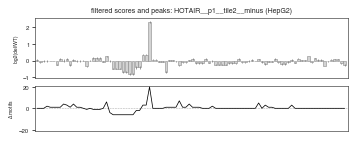

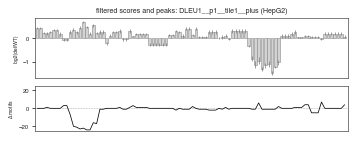

K562


In [43]:
hepg2_all_dels_tfs = pd.DataFrame()
k562_all_dels_tfs = pd.DataFrame()
for dels_fixed, dels_df, cell in zip([hepg2_dels_fixed, k562_dels_fixed], [hepg2_all_dels_tfs, k562_all_dels_tfs],
                                    ["HepG2", "K562"]):
    print(cell)
    for name in dels_fixed:
        df = dels_fixed[name].sort_values(by="delpos")
        seq = list(df["seq"])
        scores = list(df["mean.log2FC"])
        yerrs = list(df["se"])

        # get wt motif # for reference
        del_id = df.del_id.iloc[0]
        wt_tfs = tfbs_wt[tfbs_wt["del_id"] == del_id]["n_tfs"].iloc[0]
        df["delta_tfs"] = df["n_tfs"] - wt_tfs
        motif_vals = list(df["delta_tfs"])
        dels_df = dels_df.append(df)

        # plot
        if name == "HOTAIR__p1__tile2__minus" and cell == "HepG2":
            plot_peaks_and_tfbs((5.6, 2.5), 94, name, cell, scores, yerrs, 
                                motif_vals, seq, "Fig_3C", True)
        if name == "DLEU1__p1__tile1__plus" and cell == "HepG2":
            plot_peaks_and_tfbs((5.6, 2.5), 94, name, cell, scores, yerrs, 
                                motif_vals, seq, "Fig_S9B", True)
        
    if cell == "HepG2":
        hepg2_all_dels_tfs = dels_df.copy()
    else:
        k562_all_dels_tfs = dels_df.copy()

## 8. compare effect sizes w/ number of motifs gained or lost (for all seqs)

In [44]:
# hepg2
hepg2_all_dels_tfs["delta_tfs_abs"] = np.abs(hepg2_all_dels_tfs["delta_tfs"])
hepg2_all_dels_tfs["del_abs"] = np.abs(hepg2_all_dels_tfs["mean.log2FC"])
hepg2_all_dels_tfs["delta_tfs_log"] = np.log(hepg2_all_dels_tfs["delta_tfs"]+1)
no_nans = hepg2_all_dels_tfs[~pd.isnull(hepg2_all_dels_tfs["mean.log2FC"])]
sig_only = hepg2_all_dels_tfs[hepg2_all_dels_tfs["sig"] == "sig"]
len(sig_only)

922

HepG2


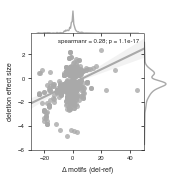

In [45]:
g = sns.jointplot(data=sig_only, x="delta_tfs", y="mean.log2FC", kind="reg", space=0, size=2.5, 
                  stat_func=spearmanr, 
                  marginal_kws={"hist": False}, color="darkgrey", scatter_kws={"s": 25})
print("HepG2")
g.set_axis_labels(r"$\Delta$ motifs (del-ref)", "deletion effect size")
g.savefig("Fig_3B.pdf", bbox_inches="tight", dpi="figure")

In [46]:
# k562
k562_all_dels_tfs["delta_tfs_abs"] = np.abs(k562_all_dels_tfs["delta_tfs"])
k562_all_dels_tfs["del_abs"] = np.abs(k562_all_dels_tfs["mean.log2FC"])
k562_all_dels_tfs["delta_tfs_log"] = np.log(k562_all_dels_tfs["delta_tfs"]+1)
no_nans = k562_all_dels_tfs[~pd.isnull(k562_all_dels_tfs["mean.log2FC"])]
sig_only = k562_all_dels_tfs[k562_all_dels_tfs["sig"] == "sig"]
len(sig_only)

223

K562


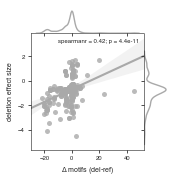

In [47]:
g = sns.jointplot(data=sig_only, x="delta_tfs", y="mean.log2FC", kind="reg", space=0, size=2.5, 
                  stat_func=spearmanr, 
                  marginal_kws={"hist": False}, color="darkgrey", scatter_kws={"s": 25})
print("K562")
g.set_axis_labels(r"$\Delta$ motifs (del-ref)", "deletion effect size")
g.savefig("Fig_S9A.pdf", bbox_inches="tight", dpi="figure")